# Sampling-based planning

In this exercise, you will
* Implement the base building blocks for a RRT planner
* Use simple 2D occupancy maps (images)
* Implement different sampling strategies
* .. and play around with different maps


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from exercise_code import SimpleOccupancyMap
from matplotlib import collections  as mc


# The map representation

The "SimpleOccupancyMap" can load a png as a $2D$ occupancy grid and provides a simple API to access the map.

Most important functions are demonstrated in the following.


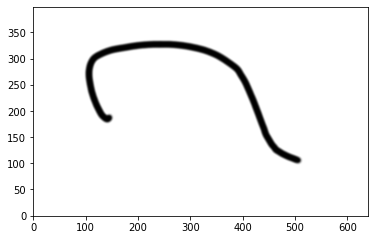

In [7]:
# Creating a new map based on a PNG
occupancy_map = SimpleOccupancyMap("simple_map.png")

# Displaying the map
occupancy_map.show()

In [8]:
# sampling random locations in the map
random_state = occupancy_map.sample_state()
print(random_state)

[ 53 338]


In [9]:
# Checking if a location is occupied or not
print(occupancy_map.is_occupied(200, 200)) # x, y

False


# RRT Skeleton
In the following, we'll provide a very simple RRT Skeleton.
In subsequent exercises, we will extend and change this.

The skeleton contains the basic algorithm as well as the needed methods (but not implemented).

In [10]:

class RRTSkeleton:
    
    def __init__(self, occ_map):
        self._map = occ_map
        self._valid_edges = []   # keeps all valid checked edges in format [ix_vertex_a, ix_vertex_b],
                                 # where ix_vertex corresponds to the vertex's index in _valid_vertices
        self._valid_vertices = []
    
    # Returns a random state in R^2
    def sample_new_state(self):
        return np.array([0.0, 0.0])
    
    # Returns True if state is valid (freespace in our case)
    def is_state_valid(self, state):
        return False
    
    # Returns True if straight-line segment between state_a and state_b
    # is admissible (going through freespace)
    def is_segment_valid(self, state_a, state_b):
        return True
    
    # Returns nearest neighbour of state
    # already present in valid_vertices
    def get_nearest_vertex(self, state):
        return state
    
    # Returns True if state is within some tolerance of the goal
    # (to determine final state)
    def is_goal_in_reach(self, state, goal, tolerance_in_px):
        return np.linalg.norm(goal-state) < tolerance_in_px
    
    def runRRT(self, start, goal, max_iter = 6000):
        
        # Initialize tree storage
        self._valid_edges = []   # keeps all valid checked edges
        self._valid_vertices = [start]
        
        goal_reached = False
        self._start = start
        self._goal = goal
        curr_iter = 0
        
        
        while not goal_reached and curr_iter < max_iter:
            curr_iter += 1
    
            new_state = self.sample_new_state()

            # Ignore if state is not valid
            if not self.is_state_valid(new_state):
                continue

            # get closest valid vertex to new_state
            nearest_vertex_id = self.get_nearest_vertex(new_state)
            nearest_vertex = self._valid_vertices[nearest_vertex_id]

            # check if we can connect
            if not self.is_segment_valid(new_state, nearest_vertex):
                continue

            # add new state to tree
            self._valid_vertices.append(new_state)
            new_state_id = len(self._valid_vertices)-1
            self._valid_edges.append([nearest_vertex_id, new_state_id])

            # if goal is close enough, terminate
            if self.is_goal_in_reach(goal, new_state, 20):
                goal_reached = True
                
            
        print("RRT terminated after " + str(curr_iter) + " iterations.")
                        
                
    # Helper function to plot output
    def plotRRT(self):
        # create line collection with coordinates
        edges_to_plot = np.array([[self._valid_vertices[edge[0]],
                                   self._valid_vertices[edge[1]]] for edge in self._valid_edges])

        lc = mc.LineCollection(edges_to_plot, linewidths=2)
        plt.rcParams['figure.figsize'] = [20, 10]

        fig, ax = plt.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        self._map.show()

        plt.scatter(*start, s=250, c='green')
        plt.scatter(*goal, s=250, c='red')

        self._map.print_statistics()

            

# Exercise 1
- RRTSimple is based on RRTSkeleton.
- It is runnable, but does not do segment checking correctly.


### Implementation task
Implement a function that plots the found path that connects the start to the goal.
Hint: valid_vertices and valid_edges contain the data and do not need to be changed.




RRT terminated after 247 iterations.
Samplings 247
Map Access 247


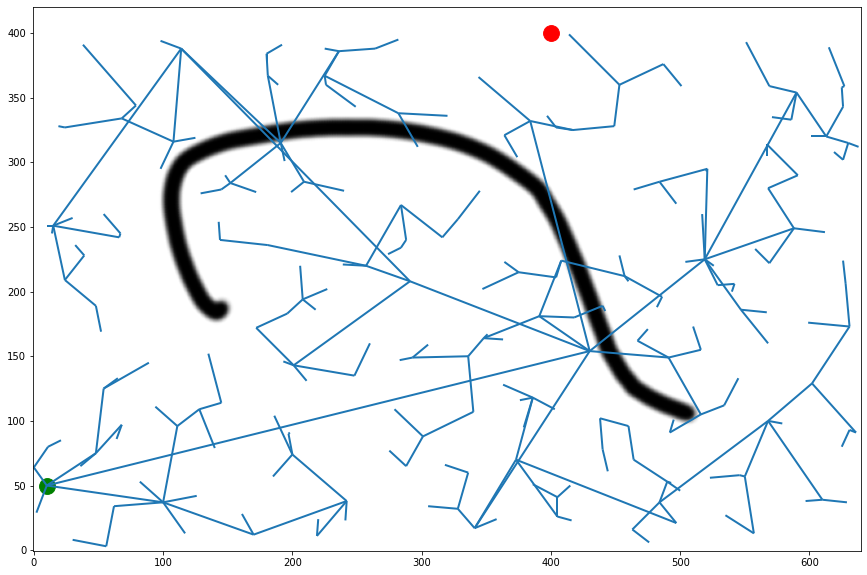

In [11]:
#Simplest RRT

class RRTSimple(RRTSkeleton):
    
    def __init__(self, occ_map):
        super(RRTSimple, self).__init__(occ_map)
        
    def sample_new_state(self):
        return self._map.sample_state()
    
    def is_state_valid(self, state):
        return not self._map.is_occupied(*state)
    
    def get_nearest_vertex(self, state):
        # get distance of each vertex in self._valid_vertices to state
        distances = np.subtract(np.array(self._valid_vertices), state)
        distances = np.sum(np.power(distances, 2), axis=1)
        
        # get vertex id corresponding to lowest distance
        return np.argmin(distances)

    
    def plot_path(self):
        # to be implemented
        return



occupancy_map = SimpleOccupancyMap("simple_map.png")

ex1 = RRTSimple(occupancy_map)


start = np.array([10, 50])
goal = np.array([400, 400])
ex1.runRRT(start, goal)
ex1.plotRRT()
ex1.plot_path()
plt.show()


# Exercise 2a


### Implementation task
Implement a segment checker that uses the map's is_occupied function


### Observation task
How do different design choices/checking resolution in the segment checker affect performance and validity of the solution? 
The plotRRT function outputs statistics in terms of map accesses and sampled states.



RRT terminated after 291 iterations.
Samplings 291
Map Access 291


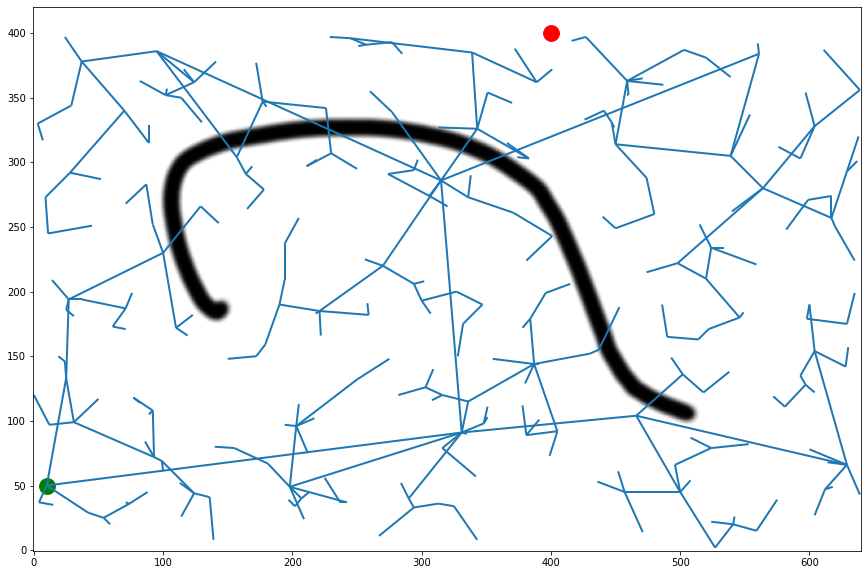

In [12]:

class RRTCorrect(RRTSimple):
    
    def __init__(self, occ_map):
        super(RRTCorrect, self).__init__(occ_map)
        
    def is_segment_valid(self, state_a, state_b):
        return True

    
occupancy_map = SimpleOccupancyMap("simple_map.png")

ex2 = RRTCorrect(occupancy_map)


start = np.array([10, 50])
goal = np.array([400, 400])
ex2.runRRT(start, goal)
ex2.plotRRT()
ex2.plot_path()
plt.show()

# Exercise 2b/c



### Observation task
How do the observations from Excercise 2a change with the following two maps?



RRT terminated after 417 iterations.
Samplings 417
Map Access 38485


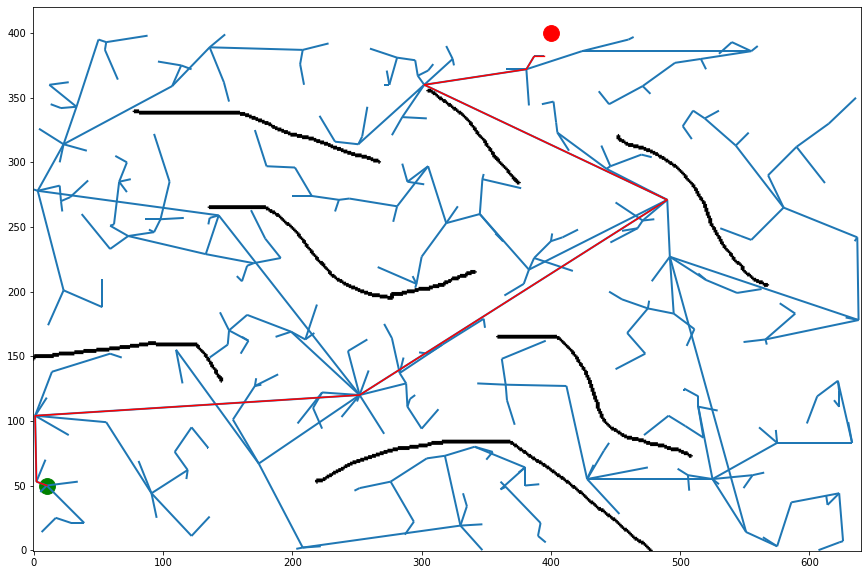

In [217]:

ex2b = RRTCorrect(SimpleOccupancyMap("fine_map.png"))

start = np.array([10, 50])
goal = np.array([400, 400])
ex2b.runRRT(start, goal)
ex2b.plotRRT()
ex2b.plot_path()
plt.show()

RRT terminated after 1442 iterations.
Samplings 1442
Map Access 97927


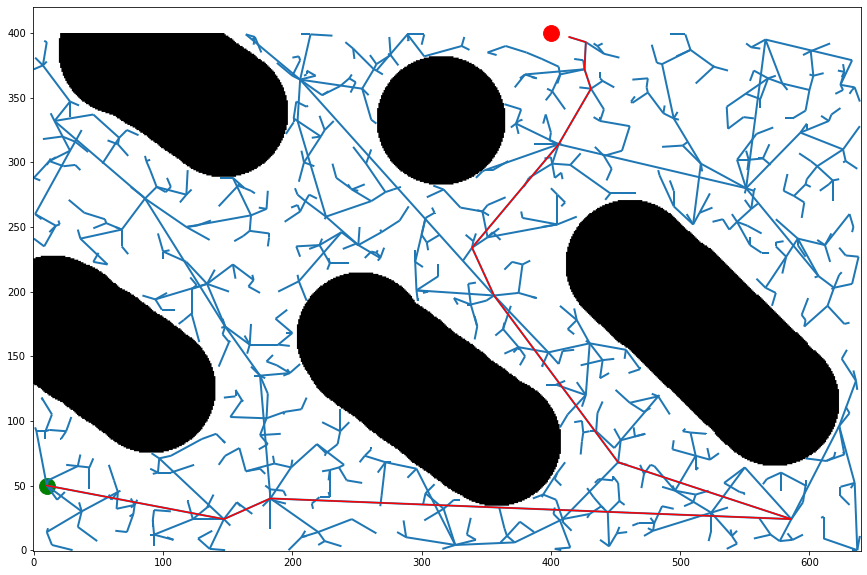

In [218]:
ex2c = RRTCorrect(SimpleOccupancyMap("coarse_map.png"))

start = np.array([10, 50])
goal = np.array([400, 400])
ex2c.runRRT(start, goal)
ex2c.plotRRT()
ex2c.plot_path()
plt.show()

# Exercise 3

### Observation task
Observe the behavior of the algorithm on the following map "dense.png".

What might be the issue and how could it be mitigated/solved?


Let Michael know about your idea for a fix and he will, in case its correct, give you the hint to go on with exercise 4.

RRT terminated after 460 iterations.
Samplings 460
Map Access 460


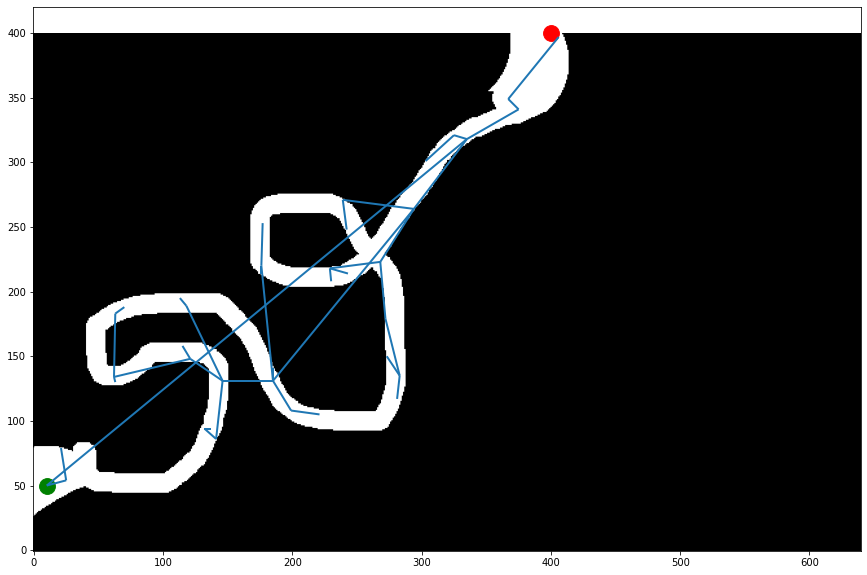

In [13]:
ex3 = RRTCorrect(SimpleOccupancyMap("dense.png"))

start = np.array([10, 50])
goal = np.array([400, 400])
ex3.runRRT(start, goal)
ex3.plotRRT()
ex3.plot_path()
plt.show()

# Exercise 4


### Implementation task
Implent a fix for the issue in Exercise 3 in the following skeleton class.

Hint: Only one method needs to be overwritten of the original class.

RRT terminated after 16 iterations.
Samplings 16
Map Access 16


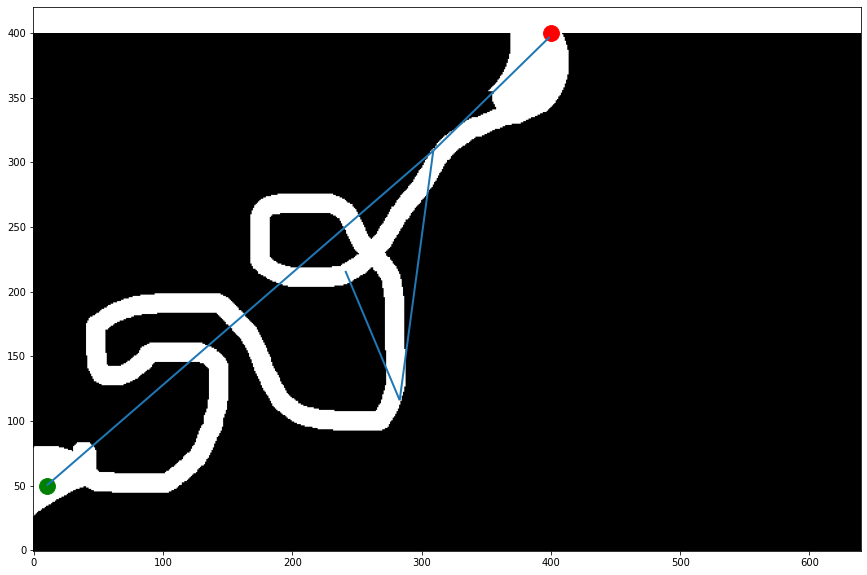

In [14]:

class BetterRRT(RRTCorrect):
    def __init__(self, occ_map):
        super(BetterRRT, self).__init__(occ_map)
        
    
ex4 = BetterRRT(SimpleOccupancyMap("dense.png"))

start = np.array([10, 50])
goal = np.array([400, 400])
ex4.runRRT(start, goal)
ex4.plotRRT()
ex4.plot_path()
plt.show() 

# Exercise 5

### Observation task
What is the problem on the "narrow" map?

### Implementation task (optional)
There is an indirect mitigation for this problem. What do you think is it and how would a solution look like?

RRT terminated after 352 iterations.
Samplings 352
Map Access 352


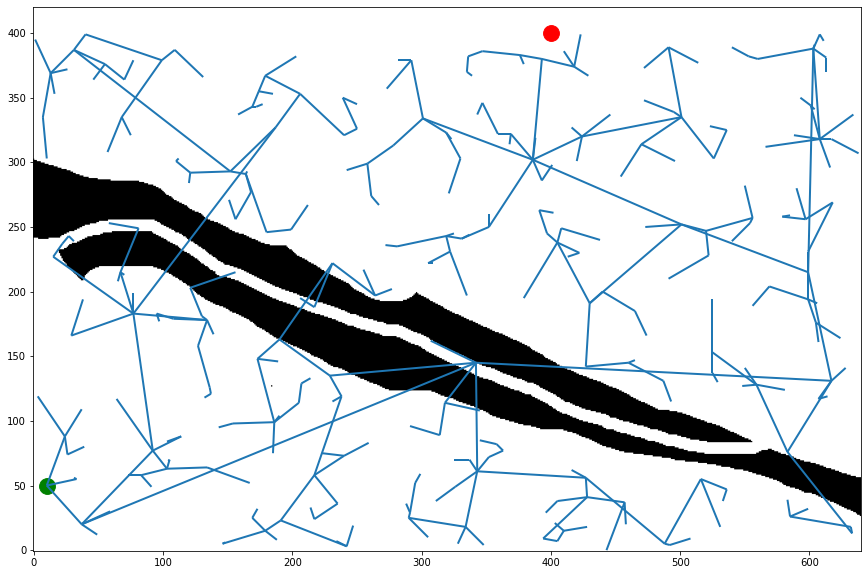

In [15]:
  
ex5 = BetterRRT(SimpleOccupancyMap("narrow.png"))

start = np.array([10, 50])
goal = np.array([400, 400])
ex5.runRRT(start, goal)
ex5.plotRRT()
ex5.plot_path()
plt.show() 